In [1]:
# Capital Bike Share data - Model Optimization

In [2]:
import numpy as np

import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

In [3]:
train = pd.read_csv('train_bikes.csv', index_col=0, parse_dates=True)
test = pd.read_csv('test_bikes.csv', index_col=0, parse_dates=True)

In [4]:
train.shape, test.shape

((10886, 11), (6493, 8))

In [5]:
# creating functions for data wrangling/feature engineering train and test datasets 

# attn: incorporating MinMaxScaler() in the pipelines, so not including in these functions

In [6]:
def wrangle_train_data(df):
    
    # DateTimeIndex-ifying
    df['datetime'] = pd.to_datetime(df.index)
    df['year'] = pd.DatetimeIndex(df['datetime']).year
    df['month'] = pd.DatetimeIndex(df['datetime']).month
    df['day'] = pd.DatetimeIndex(df['datetime']).day
    df['hour'] = pd.DatetimeIndex(df['datetime']).hour
    df = df.drop(['datetime'], axis=1)
    
    # coercing into categorical datatype
    cat_var_list = ['season', 'holiday', 'workingday', 'year', 'month', 'day', 'hour']
    for var in cat_var_list:
        df[var] = df[var].astype('category')
    
    # drop columns that are not useful
    df = df.drop(['atemp'], axis=1)
    df = df.drop(['casual'], axis=1)
    df = df.drop(['registered'], axis=1)
    df = df.drop(['day'], axis=1)

    # outlier removal
    df = df[np.abs(df['count'] - df['count'].mean()) <= (3 * df['count'].std())]
        
    # Binning temp data: into bins of 5 deg (C or F?)
    df['binned_temp'] = np.floor(df['temp']) // 5

    # Binning hour data: into 6 bins of 4 hours each
    df['binned_hour'] = pd.cut(df['hour'], bins=6)

    # creating dummies for categorial calues, and dropping original columns 
    dummy_list = ['season', 'weather', 'workingday', 'holiday', 'binned_temp', 'binned_hour', 
                  'year', 'month', 'hour']
    for dummy in dummy_list:
        try:
            df = pd.get_dummies(data=df, prefix=dummy_list, columns=dummy_list, drop_first=True)
        except: 
            Exception
            continue
    return df

In [7]:
train = wrangle_train_data(train)

In [8]:
train.shape

(10739, 60)

In [9]:
train.head(1)

,temp,humidity,windspeed,count,season_2,season_3,season_4,weather_2,weather_3,weather_4,workingday_1,holiday_1,binned_temp_1.0,binned_temp_2.0,binned_temp_3.0,binned_temp_4.0,binned_temp_5.0,binned_temp_6.0,binned_temp_7.0,binned_temp_8.0,"binned_hour_(3.833, 7.667]","binned_hour_(7.667, 11.5]","binned_hour_(11.5, 15.333]","binned_hour_(15.333, 19.167]","binned_hour_(19.167, 23.0]",year_2012,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01,9.84,81,0.0,16,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
def wrangle_test_data(df):
    
    # DateTimeIndex-ifying
    df['datetime'] = pd.to_datetime(df.index)
    df['year'] = pd.DatetimeIndex(df['datetime']).year
    df['month'] = pd.DatetimeIndex(df['datetime']).month
    df['day'] = pd.DatetimeIndex(df['datetime']).day
    df['hour'] = pd.DatetimeIndex(df['datetime']).hour
    df = df.drop(['datetime'], axis=1)
    
    # coercing into categorical datatype
    cat_var_list = ['season', 'holiday', 'workingday', 'year', 'month', 'day', 'hour']
    for var in cat_var_list:
        df[var] = df[var].astype('category')
    
    # drop columns that are not useful
    df = df.drop(['atemp'], axis=1)
    df = df.drop(['day'], axis=1)
     
    # Binning temp data: into bins of 5 deg (C or F?)
    df['binned_temp'] = np.floor(df['temp']) // 5

    # Binning hour data: into 6 bins of 4 hours each
    df['binned_hour'] = pd.cut(df['hour'], bins=6)

    # creating dummies for categorial calues, and dropping original columns 
    dummy_list = ['season', 'weather', 'workingday', 'holiday', 'binned_temp', 'binned_hour', 
                  'year', 'month', 'hour']
    for dummy in dummy_list:
        try:
            df = pd.get_dummies(data=df, prefix=dummy_list, columns=dummy_list, drop_first=True)
        except: 
            Exception
            continue
    return df

In [11]:
test = wrangle_test_data(test)

In [12]:
test.shape

(6493, 59)

In [13]:
test.head(1)

,temp,humidity,windspeed,season_2,season_3,season_4,weather_2,weather_3,weather_4,workingday_1,holiday_1,binned_temp_1.0,binned_temp_2.0,binned_temp_3.0,binned_temp_4.0,binned_temp_5.0,binned_temp_6.0,binned_temp_7.0,binned_temp_8.0,"binned_hour_(3.833, 7.667]","binned_hour_(7.667, 11.5]","binned_hour_(11.5, 15.333]","binned_hour_(15.333, 19.167]","binned_hour_(19.167, 23.0]",year_2012,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-20,10.66,56,26.0027,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
# Selected features after statistical analysis 

X = train[['temp','season_2','season_3','season_4','weather_2','weather_3','workingday_1',
'humidity','windspeed','binned_temp_1.0','binned_temp_2.0','binned_temp_3.0','binned_temp_4.0',
'binned_temp_5.0','binned_hour_(3.833, 7.667]','binned_hour_(7.667, 11.5]','binned_hour_(11.5, 15.333]',
'binned_hour_(15.333, 19.167]','binned_hour_(19.167, 23.0]','year_2012','month_2','month_3',
'month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_1','hour_2','hour_3',
'hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_11','hour_12','hour_13','hour_14',
'hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23']].to_numpy()

y = np.log1p(train['count'])

In [15]:
X.shape, y.shape

((10739, 52), (10739,))

In [16]:
# Model Comparison 

In [17]:
# first spliting training data into train and validation sets

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((8591, 52), (2148, 52), (8591,), (2148,))

In [19]:
# comparing LinearRegression (used during Feature Selection) with Ridge, Lasso & Elastic Nets
# along with PolynomialFeatures() and MixMaxScaler() in the pipeline function of sklearn

In [20]:
# Pipe1: Linear Regression

pipe1 = make_pipeline(PolynomialFeatures(degree=2), MinMaxScaler(), LinearRegression(n_jobs=-1))

pipe1.fit(X_train, y_train)
print('Linear Regression (training score): ', pipe1.score(X_train, y_train))

Linear Regression (training score):  0.9560290433730312


In [21]:
# Pipe2: Ridge

pipe2 = make_pipeline(PolynomialFeatures(degree=2), MinMaxScaler(), Ridge(alpha=0.1))

pipe2.fit(X_train, y_train)


Ridge (training score):  0.956077422310054


In [22]:
# Pipe3: Lasso

pipe3 = make_pipeline(PolynomialFeatures(degree=2), MinMaxScaler(), Lasso(alpha=0.1))

pipe3.fit(X_train, y_train)
print('Ridge (training score): ', pipe3.score(X_train, y_train))

Ridge (training score):  0.2269989319339899


In [23]:
# Pipe4: ElasticNet

pipe4 = make_pipeline(PolynomialFeatures(degree=2), MinMaxScaler(), ElasticNet(alpha=0.1))

pipe4.fit(X_train, y_train)
print('Ridge (training score): ', pipe4.score(X_train, y_train))

Ridge (training score):  0.4906483632547475


In [24]:
# Ridge appears to be the best, but strangely not much better than plain old Linear Regression

In [25]:
# MSE: cool fairly low

y_pred_ridge = pipe2.predict(X_val)
print('MSE Ridge: ', mean_squared_error(y_val, y_pred_ridge))

MSE Ridge:  0.10408057513532153


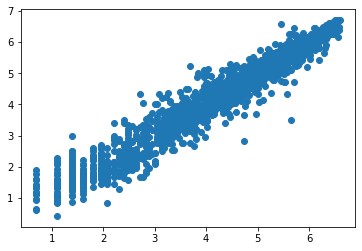

In [26]:
# seems fairly tight for starters

plt.scatter(y_val, y_pred_ridge)

In [27]:
# Cross Validation

In [28]:
# Cross validation: using r2_score (R^2 (coefficient of determination) regression score function.
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0 

scores_r2 = cross_val_score(pipe2, X_train, y_train, cv=10, scoring='r2')
print('Scores_r2:', scores_r2)
print('Mean_r2:', scores_r2.mean())
print('STD_r2:', scores_r2.std())

Scores_r2: [0.94996467 0.94325159 0.94226051 0.95068238 0.94567324 0.94351932
 0.94284831 0.94376814 0.94418811 0.94617692]
Mean_r2: 0.9452333188654425
STD_r2: 0.0027891206524859468


In [29]:
# comparing with MSE: attn this metric is the negative of MSE

scores_mse = cross_val_score(pipe2, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('Scores_mse:', scores_mse)
print('Mean_mse:', scores_mse.mean())
print('STD_mse:', scores_mse.std())

Scores_mse: [-0.10422275 -0.11639284 -0.11742553 -0.09540848 -0.10424193 -0.10440791
 -0.11478091 -0.10912521 -0.1102052  -0.11813142]
Mean_mse: -0.10943421840468193
STD_mse: 0.007023575101234331


In [30]:
# seems fairly consistent for both metrics

In [31]:
# Hyperparameter Optimization

In [32]:
params = {'polynomialfeatures__degree': [1, 2, 3], 
          'ridge__alpha': [1.0, 0.1, 0.01, 0.001]}

hyp_opt = GridSearchCV(pipe2, params).fit(X_train, y_train)

In [33]:
hyp_opt.best_params_

{'polynomialfeatures__degree': 2, 'ridge__alpha': 1.0}

In [35]:
# Rerunning pipe2 with these parameters

In [36]:
pipe2 = make_pipeline(PolynomialFeatures(degree=2), MinMaxScaler(), Ridge(alpha=1))

In [37]:
pipe2.fit(X_train, y_train)
print('Ridge (training score, post hyperparam optimization): ', pipe2.score(X_train, y_train))

Ridge (training score, post hyperparam optimization):  0.9556182806264542


In [ ]:
# no improvement - model already at its best?? 

In [40]:
# Prediction for final submission

In [41]:
X_submission = test[['temp','season_2','season_3','season_4','weather_2','weather_3','workingday_1',
'humidity','windspeed','binned_temp_1.0','binned_temp_2.0','binned_temp_3.0','binned_temp_4.0',
'binned_temp_5.0','binned_hour_(3.833, 7.667]','binned_hour_(7.667, 11.5]','binned_hour_(11.5, 15.333]',
'binned_hour_(15.333, 19.167]','binned_hour_(19.167, 23.0]','year_2012','month_2','month_3',
'month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_1','hour_2','hour_3',
'hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_11','hour_12','hour_13','hour_14',
'hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23']].to_numpy()

In [43]:
y_submission = pipe2.predict(X_submission)
y_submission

array([2.4663069 , 1.74228504, 1.35695266, ..., 4.8007694 , 4.63111555,
       4.10272181])

In [44]:
# attn: for final predictive score, inverse np.exp(y)-1 has to be applied!

y_final_submission = np.exp(y_submission) - 1
y_final_submission

array([ 10.77886594,   4.71037697,   2.88433835, ..., 120.60394336,
       101.6284876 ,  59.50474582])

In [45]:
test.index

DatetimeIndex(['2011-01-20 00:00:00', '2011-01-20 01:00:00',
               '2011-01-20 02:00:00', '2011-01-20 03:00:00',
               '2011-01-20 04:00:00', '2011-01-20 05:00:00',
               '2011-01-20 06:00:00', '2011-01-20 07:00:00',
               '2011-01-20 08:00:00', '2011-01-20 09:00:00',
               ...
               '2012-12-31 14:00:00', '2012-12-31 15:00:00',
               '2012-12-31 16:00:00', '2012-12-31 17:00:00',
               '2012-12-31 18:00:00', '2012-12-31 19:00:00',
               '2012-12-31 20:00:00', '2012-12-31 21:00:00',
               '2012-12-31 22:00:00', '2012-12-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=6493, freq=None)

In [ ]:
# to create the submission file
# my_submission = pd.DataFrame({'id': test.index, 'count': y_final_submission})
# my_submission.to_csv('submission.cvs', index=False)